# Baseline Model Using Flair For NER Task

This notebook establishes a baseline model for the **named entity recognition (NER) task**. We'll be training a model using Flair embeddings on a subset of the [annotated NER corpus](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus) dataset.

## Setup

Open this notebook in **Google Colab** and remember to turn on the GPU.

In [1]:
!nvidia-smi

Sat Dec  3 16:20:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install dependencies:

In [2]:
!pip install -q flair

## Load In Data

In a prevous notebook, we created training, validation, and test sets in a text file format that Flair can read. **Upload those files to Colab.**

Read in text files to Flair (according to [Tutorial 6: Corpus](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_6_CORPUS.md#reading-your-own-sequence-labeling-dataset)):

In [3]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# Columns in the text files
columns = {0: 'text', 1: 'pos', 2: 'ner'}

# Data folder in which train, test and dev files reside
data_folder = '.'

# Initialize a corpus using column format, data folder and the names of the train, dev and test files
corpus = ColumnCorpus(data_folder, columns,
                              train_file='ner_flair_train_tiny.txt',
                            #   test_file='ner_flair_test.txt',
                              dev_file='ner_flair_valid.txt')

# Print the number of sentences read in
len(corpus.train), len(corpus.dev), len(corpus.test)

2022-12-03 16:21:14,862 Reading data from .
2022-12-03 16:21:14,863 Train: ner_flair_train_tiny.txt
2022-12-03 16:21:14,868 Dev: ner_flair_valid.txt
2022-12-03 16:21:14,873 Test: None


(4291, 4778, 477)

Training will run significantly faster (and we can avoid out-of-memory errors) if we use `ner_flair_train_tiny.txt` instead of full-sized `ner_flair_train.txt`, so we are using 'tiny' for establishing a baseline.

Note that when `test_file` is omitted in `ColumnCorpus` above, Flair automatically grabs some data for `test_file` from `train_file`. That's fine, as we will ignore the test results below and only focus on the validation (dev) set. Keep the `test_file` line commented out because there is an unknown entity within it that gives an error during training because it's not in our corpus dictionary. We will investigate this issue further in future work.

## Training

To train a NER model using **Flair embeddings**, we follow [Tutorial 7: NER Training With Flair](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md#training-a-named-entity-recognition-ner-model-with-flair-embeddings), [Training Custom NER Model Using Flair](https://medium.com/thecyphy/training-custom-ner-model-using-flair-df1f9ea9c762), and [Train a NER Model](https://news.machinelearning.sg/posts/train_a_named_entity_recognition_model_using_flair/). For more details on Flair embeddings, see [Tutorial 3: Word Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md) and [Tutorial 4: List of All Word Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_4_ELMO_BERT_FLAIR_EMBEDDING.md).

The benefit of **training a model vs. using a pre-trained model** is that with the former, we can learn our dataset's **custom entities**. With the latter, we would be limited to that particular model's entities.

In [8]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# Specify the NER label
label_type = 'ner'

# Make the label dictionary from the corpus
label_dict = corpus.make_label_dictionary(label_type=label_type)

# Initialize embedding stack with Flair and GloVe
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

# Initialize sequence tagger
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

# Initialize trainer
trainer = ModelTrainer(tagger, corpus)

# Start training
trainer.train('ner_03_results',
              learning_rate=0.1,
              mini_batch_size=32,
              write_weights=True,
              embeddings_storage_mode='cpu',
              max_epochs=100)

2022-12-03 16:23:49,350 Computing label dictionary. Progress:


4291it [00:00, 44124.81it/s]

2022-12-03 16:23:49,458 Dictionary created for label 'ner' with 9 values: geo (seen 3185 times), org (seen 1761 times), tim (seen 1694 times), gpe (seen 1620 times), per (seen 1566 times), art (seen 71 times), eve (seen 50 times), nat (seen 28 times)


2022-12-03 16:23:51,897 SequenceTagger predicts: Dictionary with 33 tags: O, S-geo, B-geo, E-geo, I-geo, S-org, B-org, E-org, I-org, S-tim, B-tim, E-tim, I-tim, S-gpe, B-gpe, E-gpe, I-gpe, S-per, B-per, E-per, I-per, S-art, B-art, E-art, I-art, S-eve, B-eve, E-eve, I-eve, S-nat, B-nat, E-nat, I-nat
2022-12-03 16:23:52,103 ----------------------------------------------------------------------------------------------------
2022-12-03 16:23:52,106 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
   

100%|██████████| 150/150 [01:05<00:00,  2.29it/s]

2022-12-03 16:25:30,039 Evaluating as a multi-label problem: False
2022-12-03 16:25:30,143 DEV : loss 0.29063940048217773 - f1-score (micro avg)  0.6454


2022-12-03 16:25:30,625 BAD EPOCHS (no improvement): 0
2022-12-03 16:25:30,632 saving best model
2022-12-03 16:25:32,661 ----------------------------------------------------------------------------------------------------
2022-12-03 16:25:34,240 epoch 2 - iter 13/135 - loss 0.30212135 - samples/sec: 270.24 - lr: 0.100000
2022-12-03 16:25:35,636 epoch 2 - iter 26/135 - loss 0.29907757 - samples/sec: 302.52 - lr: 0.100000
2022-12-03 16:25:37,060 epoch 2 - iter 39/135 - loss 0.29006519 - samples/sec: 296.36 - lr: 0.100000
2022-12-03 16:25:38,475 epoch 2 - iter 52/135 - loss 0.29193205 - samples/sec: 298.40 - lr: 0.100000
2022-12-03 16:25:39,955 epoch 2 - iter 65/135 - loss 0.28470171 - samples/sec: 286.00 - lr: 0.100000
2022-12-03 16:25:41,427 epoch 2 - iter 78/135 - loss 0.27839673 - samples/sec: 286.76 - lr: 0.100000
2022-12-03 16:25:42,895 epoch 2 - iter 91/135 - loss 0.27857954 - samples/sec: 288.05 - lr: 0.100000
2022-12-03 16:25:44,342 epoch 2 - iter 104/135 - loss 0.27453160 - samp

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


2022-12-03 16:26:11,920 Evaluating as a multi-label problem: False
2022-12-03 16:26:12,023 DEV : loss 0.19056494534015656 - f1-score (micro avg)  0.757
2022-12-03 16:26:12,486 BAD EPOCHS (no improvement): 0
2022-12-03 16:26:12,491 saving best model
2022-12-03 16:26:14,485 ----------------------------------------------------------------------------------------------------
2022-12-03 16:26:16,036 epoch 3 - iter 13/135 - loss 0.22600266 - samples/sec: 268.99 - lr: 0.100000
2022-12-03 16:26:17,493 epoch 3 - iter 26/135 - loss 0.22135304 - samples/sec: 289.92 - lr: 0.100000
2022-12-03 16:26:18,969 epoch 3 - iter 39/135 - loss 0.21660412 - samples/sec: 286.50 - lr: 0.100000
2022-12-03 16:26:20,421 epoch 3 - iter 52/135 - loss 0.22302461 - samples/sec: 290.88 - lr: 0.100000
2022-12-03 16:26:21,852 epoch 3 - iter 65/135 - loss 0.21840016 - samples/sec: 295.65 - lr: 0.100000
2022-12-03 16:26:23,327 epoch 3 - iter 78/135 - loss 0.21712384 - samples/sec: 286.00 - lr: 0.100000
2022-12-03 16:26:24,

100%|██████████| 150/150 [00:23<00:00,  6.26it/s]


2022-12-03 16:26:53,656 Evaluating as a multi-label problem: False
2022-12-03 16:26:53,757 DEV : loss 0.1602565050125122 - f1-score (micro avg)  0.7769
2022-12-03 16:26:54,237 BAD EPOCHS (no improvement): 0
2022-12-03 16:26:54,239 saving best model
2022-12-03 16:26:56,245 ----------------------------------------------------------------------------------------------------
2022-12-03 16:26:57,823 epoch 4 - iter 13/135 - loss 0.17147688 - samples/sec: 264.27 - lr: 0.100000
2022-12-03 16:26:59,258 epoch 4 - iter 26/135 - loss 0.18234842 - samples/sec: 294.32 - lr: 0.100000
2022-12-03 16:27:00,731 epoch 4 - iter 39/135 - loss 0.18181830 - samples/sec: 286.42 - lr: 0.100000
2022-12-03 16:27:02,101 epoch 4 - iter 52/135 - loss 0.18276930 - samples/sec: 308.74 - lr: 0.100000
2022-12-03 16:27:03,561 epoch 4 - iter 65/135 - loss 0.18325213 - samples/sec: 289.13 - lr: 0.100000
2022-12-03 16:27:05,026 epoch 4 - iter 78/135 - loss 0.18605564 - samples/sec: 288.13 - lr: 0.100000
2022-12-03 16:27:06,

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]

2022-12-03 16:27:35,495 Evaluating as a multi-label problem: False


2022-12-03 16:27:35,595 DEV : loss 0.13870877027511597 - f1-score (micro avg)  0.7843
2022-12-03 16:27:36,074 BAD EPOCHS (no improvement): 0
2022-12-03 16:27:36,076 saving best model
2022-12-03 16:27:38,092 ----------------------------------------------------------------------------------------------------
2022-12-03 16:27:39,666 epoch 5 - iter 13/135 - loss 0.17216545 - samples/sec: 265.10 - lr: 0.100000
2022-12-03 16:27:41,100 epoch 5 - iter 26/135 - loss 0.16631503 - samples/sec: 294.55 - lr: 0.100000
2022-12-03 16:27:42,578 epoch 5 - iter 39/135 - loss 0.17123618 - samples/sec: 287.92 - lr: 0.100000
2022-12-03 16:27:44,034 epoch 5 - iter 52/135 - loss 0.17303481 - samples/sec: 289.86 - lr: 0.100000
2022-12-03 16:27:45,464 epoch 5 - iter 65/135 - loss 0.17167622 - samples/sec: 295.19 - lr: 0.100000
2022-12-03 16:27:46,897 epoch 5 - iter 78/135 - loss 0.16874934 - samples/sec: 295.69 - lr: 0.100000
2022-12-03 16:27:48,381 epoch 5 - iter 91/135 - loss 0.17092601 - samples/sec: 285.13 

100%|██████████| 150/150 [00:23<00:00,  6.34it/s]

2022-12-03 16:28:17,028 Evaluating as a multi-label problem: False


2022-12-03 16:28:17,175 DEV : loss 0.1347608119249344 - f1-score (micro avg)  0.7894
2022-12-03 16:28:17,994 BAD EPOCHS (no improvement): 0
2022-12-03 16:28:17,996 saving best model
2022-12-03 16:28:20,003 ----------------------------------------------------------------------------------------------------
2022-12-03 16:28:21,624 epoch 6 - iter 13/135 - loss 0.15478394 - samples/sec: 257.68 - lr: 0.100000
2022-12-03 16:28:23,098 epoch 6 - iter 26/135 - loss 0.15565079 - samples/sec: 286.42 - lr: 0.100000
2022-12-03 16:28:24,527 epoch 6 - iter 39/135 - loss 0.15588995 - samples/sec: 295.69 - lr: 0.100000
2022-12-03 16:28:25,931 epoch 6 - iter 52/135 - loss 0.15434147 - samples/sec: 300.97 - lr: 0.100000
2022-12-03 16:28:27,390 epoch 6 - iter 65/135 - loss 0.15363110 - samples/sec: 289.65 - lr: 0.100000
2022-12-03 16:28:28,875 epoch 6 - iter 78/135 - loss 0.15334453 - samples/sec: 284.06 - lr: 0.100000
2022-12-03 16:28:30,347 epoch 6 - iter 91/135 - loss 0.15454810 - samples/sec: 286.72 -

100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


2022-12-03 16:28:59,356 Evaluating as a multi-label problem: False
2022-12-03 16:28:59,459 DEV : loss 0.13658244907855988 - f1-score (micro avg)  0.7799
2022-12-03 16:28:59,929 BAD EPOCHS (no improvement): 1
2022-12-03 16:28:59,930 ----------------------------------------------------------------------------------------------------
2022-12-03 16:29:01,522 epoch 7 - iter 13/135 - loss 0.15569999 - samples/sec: 262.46 - lr: 0.100000
2022-12-03 16:29:03,000 epoch 7 - iter 26/135 - loss 0.15058171 - samples/sec: 285.75 - lr: 0.100000
2022-12-03 16:29:04,418 epoch 7 - iter 39/135 - loss 0.14240832 - samples/sec: 297.76 - lr: 0.100000
2022-12-03 16:29:05,881 epoch 7 - iter 52/135 - loss 0.14292328 - samples/sec: 290.16 - lr: 0.100000
2022-12-03 16:29:07,335 epoch 7 - iter 65/135 - loss 0.14123527 - samples/sec: 290.46 - lr: 0.100000
2022-12-03 16:29:08,843 epoch 7 - iter 78/135 - loss 0.14209178 - samples/sec: 280.21 - lr: 0.100000
2022-12-03 16:29:10,399 epoch 7 - iter 91/135 - loss 0.143789

100%|██████████| 150/150 [00:24<00:00,  6.22it/s]


2022-12-03 16:29:39,391 Evaluating as a multi-label problem: False
2022-12-03 16:29:39,486 DEV : loss 0.1197860836982727 - f1-score (micro avg)  0.8005
2022-12-03 16:29:39,962 BAD EPOCHS (no improvement): 0
2022-12-03 16:29:39,964 saving best model
2022-12-03 16:29:41,978 ----------------------------------------------------------------------------------------------------
2022-12-03 16:29:43,556 epoch 8 - iter 13/135 - loss 0.14405111 - samples/sec: 264.86 - lr: 0.100000
2022-12-03 16:29:45,018 epoch 8 - iter 26/135 - loss 0.14012081 - samples/sec: 288.74 - lr: 0.100000
2022-12-03 16:29:46,504 epoch 8 - iter 39/135 - loss 0.13998912 - samples/sec: 284.00 - lr: 0.100000
2022-12-03 16:29:47,931 epoch 8 - iter 52/135 - loss 0.13823685 - samples/sec: 296.01 - lr: 0.100000
2022-12-03 16:29:49,387 epoch 8 - iter 65/135 - loss 0.13366721 - samples/sec: 289.81 - lr: 0.100000
2022-12-03 16:29:50,867 epoch 8 - iter 78/135 - loss 0.13317183 - samples/sec: 285.65 - lr: 0.100000
2022-12-03 16:29:52,

100%|██████████| 150/150 [00:24<00:00,  6.15it/s]

2022-12-03 16:30:21,548 Evaluating as a multi-label problem: False


2022-12-03 16:30:21,667 DEV : loss 0.12232431769371033 - f1-score (micro avg)  0.784
2022-12-03 16:30:22,139 BAD EPOCHS (no improvement): 1
2022-12-03 16:30:22,141 ----------------------------------------------------------------------------------------------------
2022-12-03 16:30:23,750 epoch 9 - iter 13/135 - loss 0.12620453 - samples/sec: 259.76 - lr: 0.100000
2022-12-03 16:30:25,252 epoch 9 - iter 26/135 - loss 0.12089287 - samples/sec: 281.44 - lr: 0.100000
2022-12-03 16:30:26,737 epoch 9 - iter 39/135 - loss 0.12625686 - samples/sec: 284.53 - lr: 0.100000
2022-12-03 16:30:28,172 epoch 9 - iter 52/135 - loss 0.12857164 - samples/sec: 294.57 - lr: 0.100000
2022-12-03 16:30:29,644 epoch 9 - iter 65/135 - loss 0.12819582 - samples/sec: 287.05 - lr: 0.100000
2022-12-03 16:30:31,073 epoch 9 - iter 78/135 - loss 0.12920458 - samples/sec: 296.46 - lr: 0.100000
2022-12-03 16:30:32,498 epoch 9 - iter 91/135 - loss 0.12779861 - samples/sec: 296.19 - lr: 0.100000
2022-12-03 16:30:33,981 epoc

100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


2022-12-03 16:31:01,590 Evaluating as a multi-label problem: False
2022-12-03 16:31:01,699 DEV : loss 0.12458842992782593 - f1-score (micro avg)  0.7926
2022-12-03 16:31:02,154 BAD EPOCHS (no improvement): 2
2022-12-03 16:31:02,158 ----------------------------------------------------------------------------------------------------
2022-12-03 16:31:03,744 epoch 10 - iter 13/135 - loss 0.13162624 - samples/sec: 263.31 - lr: 0.100000
2022-12-03 16:31:05,141 epoch 10 - iter 26/135 - loss 0.12874596 - samples/sec: 302.35 - lr: 0.100000
2022-12-03 16:31:06,610 epoch 10 - iter 39/135 - loss 0.13017178 - samples/sec: 288.91 - lr: 0.100000
2022-12-03 16:31:08,126 epoch 10 - iter 52/135 - loss 0.13029587 - samples/sec: 278.43 - lr: 0.100000
2022-12-03 16:31:09,542 epoch 10 - iter 65/135 - loss 0.12964108 - samples/sec: 298.72 - lr: 0.100000
2022-12-03 16:31:11,025 epoch 10 - iter 78/135 - loss 0.12685437 - samples/sec: 284.94 - lr: 0.100000
2022-12-03 16:31:12,494 epoch 10 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


2022-12-03 16:31:41,732 Evaluating as a multi-label problem: False
2022-12-03 16:31:41,836 DEV : loss 0.11177538335323334 - f1-score (micro avg)  0.8068
2022-12-03 16:31:42,292 BAD EPOCHS (no improvement): 0
2022-12-03 16:31:42,294 saving best model
2022-12-03 16:31:44,315 ----------------------------------------------------------------------------------------------------
2022-12-03 16:31:45,974 epoch 11 - iter 13/135 - loss 0.11622322 - samples/sec: 251.58 - lr: 0.100000
2022-12-03 16:31:47,433 epoch 11 - iter 26/135 - loss 0.11179164 - samples/sec: 289.66 - lr: 0.100000
2022-12-03 16:31:48,834 epoch 11 - iter 39/135 - loss 0.11130583 - samples/sec: 302.15 - lr: 0.100000
2022-12-03 16:31:50,296 epoch 11 - iter 52/135 - loss 0.11347526 - samples/sec: 288.74 - lr: 0.100000
2022-12-03 16:31:51,719 epoch 11 - iter 65/135 - loss 0.11660775 - samples/sec: 296.95 - lr: 0.100000
2022-12-03 16:31:53,216 epoch 11 - iter 78/135 - loss 0.11560311 - samples/sec: 281.95 - lr: 0.100000
2022-12-03 16

100%|██████████| 150/150 [00:25<00:00,  5.87it/s]

2022-12-03 16:32:25,163 Evaluating as a multi-label problem: False


2022-12-03 16:32:25,285 DEV : loss 0.11426805704832077 - f1-score (micro avg)  0.8016
2022-12-03 16:32:25,980 BAD EPOCHS (no improvement): 1
2022-12-03 16:32:25,983 ----------------------------------------------------------------------------------------------------
2022-12-03 16:32:29,015 epoch 12 - iter 13/135 - loss 0.10521425 - samples/sec: 137.80 - lr: 0.100000
2022-12-03 16:32:31,044 epoch 12 - iter 26/135 - loss 0.10067969 - samples/sec: 207.21 - lr: 0.100000
2022-12-03 16:32:32,960 epoch 12 - iter 39/135 - loss 0.10809623 - samples/sec: 221.90 - lr: 0.100000
2022-12-03 16:32:34,486 epoch 12 - iter 52/135 - loss 0.10983886 - samples/sec: 276.61 - lr: 0.100000
2022-12-03 16:32:36,270 epoch 12 - iter 65/135 - loss 0.11281141 - samples/sec: 235.93 - lr: 0.100000
2022-12-03 16:32:38,310 epoch 12 - iter 78/135 - loss 0.11213180 - samples/sec: 214.45 - lr: 0.100000
2022-12-03 16:32:40,157 epoch 12 - iter 91/135 - loss 0.11315933 - samples/sec: 227.77 - lr: 0.100000
2022-12-03 16:32:41,

100%|██████████| 150/150 [00:22<00:00,  6.55it/s]


2022-12-03 16:33:08,857 Evaluating as a multi-label problem: False
2022-12-03 16:33:08,957 DEV : loss 0.10896037518978119 - f1-score (micro avg)  0.8061
2022-12-03 16:33:09,430 BAD EPOCHS (no improvement): 2
2022-12-03 16:33:09,432 ----------------------------------------------------------------------------------------------------
2022-12-03 16:33:10,999 epoch 13 - iter 13/135 - loss 0.09685331 - samples/sec: 266.17 - lr: 0.100000
2022-12-03 16:33:12,461 epoch 13 - iter 26/135 - loss 0.09739115 - samples/sec: 289.02 - lr: 0.100000
2022-12-03 16:33:13,934 epoch 13 - iter 39/135 - loss 0.10257530 - samples/sec: 286.64 - lr: 0.100000
2022-12-03 16:33:15,432 epoch 13 - iter 52/135 - loss 0.10851184 - samples/sec: 281.92 - lr: 0.100000
2022-12-03 16:33:16,882 epoch 13 - iter 65/135 - loss 0.10836737 - samples/sec: 291.31 - lr: 0.100000
2022-12-03 16:33:18,330 epoch 13 - iter 78/135 - loss 0.10997105 - samples/sec: 291.66 - lr: 0.100000
2022-12-03 16:33:19,758 epoch 13 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.19it/s]


2022-12-03 16:33:48,967 Evaluating as a multi-label problem: False
2022-12-03 16:33:49,077 DEV : loss 0.10270203649997711 - f1-score (micro avg)  0.8123
2022-12-03 16:33:49,538 BAD EPOCHS (no improvement): 0
2022-12-03 16:33:49,541 saving best model
2022-12-03 16:33:52,021 ----------------------------------------------------------------------------------------------------
2022-12-03 16:33:53,604 epoch 14 - iter 13/135 - loss 0.11549393 - samples/sec: 264.20 - lr: 0.100000
2022-12-03 16:33:55,060 epoch 14 - iter 26/135 - loss 0.10685850 - samples/sec: 290.07 - lr: 0.100000
2022-12-03 16:33:56,439 epoch 14 - iter 39/135 - loss 0.10331429 - samples/sec: 306.14 - lr: 0.100000
2022-12-03 16:33:57,851 epoch 14 - iter 52/135 - loss 0.10531224 - samples/sec: 299.22 - lr: 0.100000
2022-12-03 16:33:59,322 epoch 14 - iter 65/135 - loss 0.10459117 - samples/sec: 286.92 - lr: 0.100000
2022-12-03 16:34:01,102 epoch 14 - iter 78/135 - loss 0.10600411 - samples/sec: 236.76 - lr: 0.100000
2022-12-03 16

100%|██████████| 150/150 [00:26<00:00,  5.67it/s]


2022-12-03 16:34:34,083 Evaluating as a multi-label problem: False
2022-12-03 16:34:34,183 DEV : loss 0.1030087098479271 - f1-score (micro avg)  0.8061
2022-12-03 16:34:34,638 BAD EPOCHS (no improvement): 1
2022-12-03 16:34:34,639 ----------------------------------------------------------------------------------------------------
2022-12-03 16:34:36,206 epoch 15 - iter 13/135 - loss 0.10004629 - samples/sec: 266.83 - lr: 0.100000
2022-12-03 16:34:37,696 epoch 15 - iter 26/135 - loss 0.10337121 - samples/sec: 283.29 - lr: 0.100000
2022-12-03 16:34:39,167 epoch 15 - iter 39/135 - loss 0.10027504 - samples/sec: 287.02 - lr: 0.100000
2022-12-03 16:34:40,566 epoch 15 - iter 52/135 - loss 0.10065526 - samples/sec: 302.00 - lr: 0.100000
2022-12-03 16:34:41,947 epoch 15 - iter 65/135 - loss 0.10056995 - samples/sec: 306.00 - lr: 0.100000
2022-12-03 16:34:43,423 epoch 15 - iter 78/135 - loss 0.10272826 - samples/sec: 286.16 - lr: 0.100000
2022-12-03 16:34:44,819 epoch 15 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.20it/s]


2022-12-03 16:35:13,954 Evaluating as a multi-label problem: False
2022-12-03 16:35:14,057 DEV : loss 0.09940093755722046 - f1-score (micro avg)  0.8154
2022-12-03 16:35:14,519 BAD EPOCHS (no improvement): 0
2022-12-03 16:35:14,522 saving best model
2022-12-03 16:35:16,556 ----------------------------------------------------------------------------------------------------
2022-12-03 16:35:18,147 epoch 16 - iter 13/135 - loss 0.09888518 - samples/sec: 263.76 - lr: 0.100000
2022-12-03 16:35:19,611 epoch 16 - iter 26/135 - loss 0.09619191 - samples/sec: 288.39 - lr: 0.100000
2022-12-03 16:35:21,063 epoch 16 - iter 39/135 - loss 0.09856489 - samples/sec: 291.60 - lr: 0.100000
2022-12-03 16:35:22,527 epoch 16 - iter 52/135 - loss 0.09628791 - samples/sec: 288.45 - lr: 0.100000
2022-12-03 16:35:23,954 epoch 16 - iter 65/135 - loss 0.09725608 - samples/sec: 296.09 - lr: 0.100000
2022-12-03 16:35:25,425 epoch 16 - iter 78/135 - loss 0.09705391 - samples/sec: 286.96 - lr: 0.100000
2022-12-03 16

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


2022-12-03 16:35:55,828 Evaluating as a multi-label problem: False
2022-12-03 16:35:55,927 DEV : loss 0.10186639428138733 - f1-score (micro avg)  0.8097
2022-12-03 16:35:56,384 BAD EPOCHS (no improvement): 1
2022-12-03 16:35:56,386 ----------------------------------------------------------------------------------------------------
2022-12-03 16:35:57,924 epoch 17 - iter 13/135 - loss 0.09541398 - samples/sec: 271.48 - lr: 0.100000
2022-12-03 16:35:59,359 epoch 17 - iter 26/135 - loss 0.09581801 - samples/sec: 294.46 - lr: 0.100000
2022-12-03 16:36:01,047 epoch 17 - iter 39/135 - loss 0.09455890 - samples/sec: 249.64 - lr: 0.100000
2022-12-03 16:36:03,216 epoch 17 - iter 52/135 - loss 0.09135101 - samples/sec: 193.69 - lr: 0.100000
2022-12-03 16:36:05,341 epoch 17 - iter 65/135 - loss 0.09153754 - samples/sec: 199.42 - lr: 0.100000
2022-12-03 16:36:07,077 epoch 17 - iter 78/135 - loss 0.09535092 - samples/sec: 245.02 - lr: 0.100000
2022-12-03 16:36:08,602 epoch 17 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.13it/s]


2022-12-03 16:36:38,161 Evaluating as a multi-label problem: False
2022-12-03 16:36:38,260 DEV : loss 0.10348860174417496 - f1-score (micro avg)  0.805
2022-12-03 16:36:38,722 BAD EPOCHS (no improvement): 2
2022-12-03 16:36:38,724 ----------------------------------------------------------------------------------------------------
2022-12-03 16:36:40,321 epoch 18 - iter 13/135 - loss 0.09185929 - samples/sec: 261.72 - lr: 0.100000
2022-12-03 16:36:41,766 epoch 18 - iter 26/135 - loss 0.09399317 - samples/sec: 292.12 - lr: 0.100000
2022-12-03 16:36:43,234 epoch 18 - iter 39/135 - loss 0.09341973 - samples/sec: 288.15 - lr: 0.100000
2022-12-03 16:36:44,682 epoch 18 - iter 52/135 - loss 0.09384623 - samples/sec: 291.85 - lr: 0.100000
2022-12-03 16:36:46,093 epoch 18 - iter 65/135 - loss 0.09141390 - samples/sec: 299.58 - lr: 0.100000
2022-12-03 16:36:47,529 epoch 18 - iter 78/135 - loss 0.09108625 - samples/sec: 294.00 - lr: 0.100000
2022-12-03 16:36:48,974 epoch 18 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


2022-12-03 16:37:17,872 Evaluating as a multi-label problem: False
2022-12-03 16:37:17,972 DEV : loss 0.10596070438623428 - f1-score (micro avg)  0.8071
2022-12-03 16:37:18,446 BAD EPOCHS (no improvement): 3
2022-12-03 16:37:18,448 ----------------------------------------------------------------------------------------------------
2022-12-03 16:37:19,998 epoch 19 - iter 13/135 - loss 0.08863738 - samples/sec: 269.17 - lr: 0.100000
2022-12-03 16:37:21,422 epoch 19 - iter 26/135 - loss 0.08759037 - samples/sec: 296.71 - lr: 0.100000
2022-12-03 16:37:22,878 epoch 19 - iter 39/135 - loss 0.09201959 - samples/sec: 290.14 - lr: 0.100000
2022-12-03 16:37:24,315 epoch 19 - iter 52/135 - loss 0.09125141 - samples/sec: 294.15 - lr: 0.100000
2022-12-03 16:37:25,811 epoch 19 - iter 65/135 - loss 0.09095889 - samples/sec: 282.26 - lr: 0.100000
2022-12-03 16:37:27,213 epoch 19 - iter 78/135 - loss 0.09058500 - samples/sec: 301.42 - lr: 0.100000
2022-12-03 16:37:28,676 epoch 19 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:22<00:00,  6.56it/s]


2022-12-03 16:37:56,531 Evaluating as a multi-label problem: False
2022-12-03 16:37:56,635 DEV : loss 0.1065370962023735 - f1-score (micro avg)  0.7797
2022-12-03 16:37:57,103 Epoch    19: reducing learning rate of group 0 to 5.0000e-02.
2022-12-03 16:37:57,104 BAD EPOCHS (no improvement): 4
2022-12-03 16:37:57,108 ----------------------------------------------------------------------------------------------------
2022-12-03 16:37:58,708 epoch 20 - iter 13/135 - loss 0.09140573 - samples/sec: 260.85 - lr: 0.050000
2022-12-03 16:38:00,166 epoch 20 - iter 26/135 - loss 0.08889591 - samples/sec: 289.94 - lr: 0.050000
2022-12-03 16:38:01,569 epoch 20 - iter 39/135 - loss 0.08699290 - samples/sec: 301.49 - lr: 0.050000
2022-12-03 16:38:03,009 epoch 20 - iter 52/135 - loss 0.08585938 - samples/sec: 293.44 - lr: 0.050000
2022-12-03 16:38:04,474 epoch 20 - iter 65/135 - loss 0.08463085 - samples/sec: 288.35 - lr: 0.050000
2022-12-03 16:38:05,897 epoch 20 - iter 78/135 - loss 0.08623293 - sampl

100%|██████████| 150/150 [00:24<00:00,  6.19it/s]


2022-12-03 16:38:36,498 Evaluating as a multi-label problem: False
2022-12-03 16:38:36,596 DEV : loss 0.09972771257162094 - f1-score (micro avg)  0.8164
2022-12-03 16:38:37,055 BAD EPOCHS (no improvement): 0
2022-12-03 16:38:37,057 saving best model
2022-12-03 16:38:39,099 ----------------------------------------------------------------------------------------------------
2022-12-03 16:38:40,578 epoch 21 - iter 13/135 - loss 0.08647746 - samples/sec: 282.32 - lr: 0.050000
2022-12-03 16:38:41,982 epoch 21 - iter 26/135 - loss 0.08432960 - samples/sec: 300.82 - lr: 0.050000
2022-12-03 16:38:43,430 epoch 21 - iter 39/135 - loss 0.08133560 - samples/sec: 291.82 - lr: 0.050000
2022-12-03 16:38:44,855 epoch 21 - iter 52/135 - loss 0.08218675 - samples/sec: 296.52 - lr: 0.050000
2022-12-03 16:38:46,232 epoch 21 - iter 65/135 - loss 0.08217107 - samples/sec: 306.83 - lr: 0.050000
2022-12-03 16:38:47,681 epoch 21 - iter 78/135 - loss 0.08064762 - samples/sec: 291.30 - lr: 0.050000
2022-12-03 16

100%|██████████| 150/150 [00:28<00:00,  5.25it/s]

2022-12-03 16:39:22,636 Evaluating as a multi-label problem: False


2022-12-03 16:39:22,781 DEV : loss 0.10079874843358994 - f1-score (micro avg)  0.8118
2022-12-03 16:39:23,516 BAD EPOCHS (no improvement): 1
2022-12-03 16:39:23,524 ----------------------------------------------------------------------------------------------------
2022-12-03 16:39:25,516 epoch 22 - iter 13/135 - loss 0.07805060 - samples/sec: 209.67 - lr: 0.050000
2022-12-03 16:39:27,209 epoch 22 - iter 26/135 - loss 0.07434390 - samples/sec: 249.07 - lr: 0.050000
2022-12-03 16:39:28,741 epoch 22 - iter 39/135 - loss 0.07387670 - samples/sec: 275.29 - lr: 0.050000
2022-12-03 16:39:30,248 epoch 22 - iter 52/135 - loss 0.07509253 - samples/sec: 282.17 - lr: 0.050000
2022-12-03 16:39:31,659 epoch 22 - iter 65/135 - loss 0.07435935 - samples/sec: 299.70 - lr: 0.050000
2022-12-03 16:39:33,132 epoch 22 - iter 78/135 - loss 0.07625083 - samples/sec: 286.52 - lr: 0.050000
2022-12-03 16:39:34,621 epoch 22 - iter 91/135 - loss 0.07818699 - samples/sec: 283.50 - lr: 0.050000
2022-12-03 16:39:36,

100%|██████████| 150/150 [00:25<00:00,  5.89it/s]

2022-12-03 16:40:05,051 Evaluating as a multi-label problem: False


2022-12-03 16:40:05,164 DEV : loss 0.09914444386959076 - f1-score (micro avg)  0.8144
2022-12-03 16:40:05,641 BAD EPOCHS (no improvement): 2
2022-12-03 16:40:05,644 ----------------------------------------------------------------------------------------------------
2022-12-03 16:40:07,241 epoch 23 - iter 13/135 - loss 0.06994870 - samples/sec: 261.51 - lr: 0.050000
2022-12-03 16:40:08,699 epoch 23 - iter 26/135 - loss 0.07651695 - samples/sec: 289.86 - lr: 0.050000
2022-12-03 16:40:10,166 epoch 23 - iter 39/135 - loss 0.08173705 - samples/sec: 287.92 - lr: 0.050000
2022-12-03 16:40:11,583 epoch 23 - iter 52/135 - loss 0.08114518 - samples/sec: 298.40 - lr: 0.050000
2022-12-03 16:40:13,014 epoch 23 - iter 65/135 - loss 0.08126513 - samples/sec: 295.27 - lr: 0.050000
2022-12-03 16:40:14,514 epoch 23 - iter 78/135 - loss 0.08086013 - samples/sec: 281.51 - lr: 0.050000
2022-12-03 16:40:15,939 epoch 23 - iter 91/135 - loss 0.08050503 - samples/sec: 297.14 - lr: 0.050000
2022-12-03 16:40:17,

100%|██████████| 150/150 [00:24<00:00,  6.21it/s]


2022-12-03 16:40:44,958 Evaluating as a multi-label problem: False
2022-12-03 16:40:45,053 DEV : loss 0.10229678452014923 - f1-score (micro avg)  0.8127
2022-12-03 16:40:45,516 BAD EPOCHS (no improvement): 3
2022-12-03 16:40:45,519 ----------------------------------------------------------------------------------------------------
2022-12-03 16:40:47,116 epoch 24 - iter 13/135 - loss 0.06810020 - samples/sec: 261.35 - lr: 0.050000
2022-12-03 16:40:48,575 epoch 24 - iter 26/135 - loss 0.06943877 - samples/sec: 289.27 - lr: 0.050000
2022-12-03 16:40:50,373 epoch 24 - iter 39/135 - loss 0.06824389 - samples/sec: 234.52 - lr: 0.050000
2022-12-03 16:40:52,079 epoch 24 - iter 52/135 - loss 0.06892314 - samples/sec: 247.04 - lr: 0.050000
2022-12-03 16:40:53,516 epoch 24 - iter 65/135 - loss 0.07265240 - samples/sec: 293.84 - lr: 0.050000
2022-12-03 16:40:54,923 epoch 24 - iter 78/135 - loss 0.07370306 - samples/sec: 300.27 - lr: 0.050000
2022-12-03 16:40:56,358 epoch 24 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


2022-12-03 16:41:25,509 Evaluating as a multi-label problem: False
2022-12-03 16:41:25,608 DEV : loss 0.10497360676527023 - f1-score (micro avg)  0.8111
2022-12-03 16:41:26,075 Epoch    24: reducing learning rate of group 0 to 2.5000e-02.
2022-12-03 16:41:26,076 BAD EPOCHS (no improvement): 4
2022-12-03 16:41:26,081 ----------------------------------------------------------------------------------------------------
2022-12-03 16:41:27,613 epoch 25 - iter 13/135 - loss 0.06723312 - samples/sec: 272.56 - lr: 0.025000
2022-12-03 16:41:29,054 epoch 25 - iter 26/135 - loss 0.07321129 - samples/sec: 293.06 - lr: 0.025000
2022-12-03 16:41:30,793 epoch 25 - iter 39/135 - loss 0.07618270 - samples/sec: 244.54 - lr: 0.025000
2022-12-03 16:41:32,200 epoch 25 - iter 52/135 - loss 0.07418762 - samples/sec: 300.24 - lr: 0.025000
2022-12-03 16:41:33,624 epoch 25 - iter 65/135 - loss 0.07337257 - samples/sec: 296.65 - lr: 0.025000
2022-12-03 16:41:35,050 epoch 25 - iter 78/135 - loss 0.07403661 - samp

100%|██████████| 150/150 [00:23<00:00,  6.25it/s]


2022-12-03 16:42:05,551 Evaluating as a multi-label problem: False
2022-12-03 16:42:05,645 DEV : loss 0.10154880583286285 - f1-score (micro avg)  0.8132
2022-12-03 16:42:06,112 BAD EPOCHS (no improvement): 1
2022-12-03 16:42:06,117 ----------------------------------------------------------------------------------------------------
2022-12-03 16:42:07,663 epoch 26 - iter 13/135 - loss 0.07672364 - samples/sec: 270.21 - lr: 0.025000
2022-12-03 16:42:09,195 epoch 26 - iter 26/135 - loss 0.07301088 - samples/sec: 275.39 - lr: 0.025000
2022-12-03 16:42:10,665 epoch 26 - iter 39/135 - loss 0.07252822 - samples/sec: 287.19 - lr: 0.025000
2022-12-03 16:42:12,099 epoch 26 - iter 52/135 - loss 0.07330992 - samples/sec: 295.01 - lr: 0.025000
2022-12-03 16:42:13,542 epoch 26 - iter 65/135 - loss 0.07368996 - samples/sec: 292.52 - lr: 0.025000
2022-12-03 16:42:14,975 epoch 26 - iter 78/135 - loss 0.07336506 - samples/sec: 295.11 - lr: 0.025000
2022-12-03 16:42:16,404 epoch 26 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:22<00:00,  6.78it/s]


2022-12-03 16:42:43,333 Evaluating as a multi-label problem: False
2022-12-03 16:42:43,440 DEV : loss 0.10071013867855072 - f1-score (micro avg)  0.8105
2022-12-03 16:42:43,908 BAD EPOCHS (no improvement): 2
2022-12-03 16:42:43,910 ----------------------------------------------------------------------------------------------------
2022-12-03 16:42:45,437 epoch 27 - iter 13/135 - loss 0.06240186 - samples/sec: 273.77 - lr: 0.025000
2022-12-03 16:42:46,840 epoch 27 - iter 26/135 - loss 0.06315753 - samples/sec: 300.83 - lr: 0.025000
2022-12-03 16:42:50,024 epoch 27 - iter 39/135 - loss 0.06610827 - samples/sec: 131.56 - lr: 0.025000
2022-12-03 16:42:51,446 epoch 27 - iter 52/135 - loss 0.06890294 - samples/sec: 297.05 - lr: 0.025000
2022-12-03 16:42:52,889 epoch 27 - iter 65/135 - loss 0.06954908 - samples/sec: 292.59 - lr: 0.025000
2022-12-03 16:42:54,276 epoch 27 - iter 78/135 - loss 0.07043139 - samples/sec: 304.82 - lr: 0.025000
2022-12-03 16:42:55,743 epoch 27 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:23<00:00,  6.37it/s]


2022-12-03 16:43:24,225 Evaluating as a multi-label problem: False
2022-12-03 16:43:24,326 DEV : loss 0.10022682696580887 - f1-score (micro avg)  0.815
2022-12-03 16:43:24,809 BAD EPOCHS (no improvement): 3
2022-12-03 16:43:24,812 ----------------------------------------------------------------------------------------------------
2022-12-03 16:43:26,392 epoch 28 - iter 13/135 - loss 0.06732440 - samples/sec: 264.04 - lr: 0.025000
2022-12-03 16:43:27,787 epoch 28 - iter 26/135 - loss 0.07020374 - samples/sec: 302.85 - lr: 0.025000
2022-12-03 16:43:29,240 epoch 28 - iter 39/135 - loss 0.07227956 - samples/sec: 290.89 - lr: 0.025000
2022-12-03 16:43:30,722 epoch 28 - iter 52/135 - loss 0.07062043 - samples/sec: 286.96 - lr: 0.025000
2022-12-03 16:43:32,203 epoch 28 - iter 65/135 - loss 0.07178845 - samples/sec: 285.00 - lr: 0.025000
2022-12-03 16:43:33,645 epoch 28 - iter 78/135 - loss 0.07180763 - samples/sec: 292.74 - lr: 0.025000
2022-12-03 16:43:35,039 epoch 28 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.25it/s]


2022-12-03 16:44:03,953 Evaluating as a multi-label problem: False
2022-12-03 16:44:04,050 DEV : loss 0.10189281404018402 - f1-score (micro avg)  0.8143
2022-12-03 16:44:04,533 Epoch    28: reducing learning rate of group 0 to 1.2500e-02.
2022-12-03 16:44:04,535 BAD EPOCHS (no improvement): 4
2022-12-03 16:44:04,543 ----------------------------------------------------------------------------------------------------
2022-12-03 16:44:06,097 epoch 29 - iter 13/135 - loss 0.06361668 - samples/sec: 268.90 - lr: 0.012500
2022-12-03 16:44:07,574 epoch 29 - iter 26/135 - loss 0.06566657 - samples/sec: 285.78 - lr: 0.012500
2022-12-03 16:44:09,006 epoch 29 - iter 39/135 - loss 0.06557436 - samples/sec: 295.29 - lr: 0.012500
2022-12-03 16:44:10,395 epoch 29 - iter 52/135 - loss 0.06584404 - samples/sec: 304.61 - lr: 0.012500
2022-12-03 16:44:11,974 epoch 29 - iter 65/135 - loss 0.06520740 - samples/sec: 267.12 - lr: 0.012500
2022-12-03 16:44:13,423 epoch 29 - iter 78/135 - loss 0.06646975 - samp

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


2022-12-03 16:44:43,882 Evaluating as a multi-label problem: False
2022-12-03 16:44:43,985 DEV : loss 0.10070215910673141 - f1-score (micro avg)  0.8143
2022-12-03 16:44:44,452 BAD EPOCHS (no improvement): 1
2022-12-03 16:44:44,454 ----------------------------------------------------------------------------------------------------
2022-12-03 16:44:46,044 epoch 30 - iter 13/135 - loss 0.06444922 - samples/sec: 262.58 - lr: 0.012500
2022-12-03 16:44:47,489 epoch 30 - iter 26/135 - loss 0.06724905 - samples/sec: 292.28 - lr: 0.012500
2022-12-03 16:44:48,899 epoch 30 - iter 39/135 - loss 0.06609617 - samples/sec: 299.57 - lr: 0.012500
2022-12-03 16:44:50,316 epoch 30 - iter 52/135 - loss 0.06567395 - samples/sec: 298.14 - lr: 0.012500
2022-12-03 16:44:51,763 epoch 30 - iter 65/135 - loss 0.06527668 - samples/sec: 291.70 - lr: 0.012500
2022-12-03 16:44:53,191 epoch 30 - iter 78/135 - loss 0.06611921 - samples/sec: 296.29 - lr: 0.012500
2022-12-03 16:44:54,644 epoch 30 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.22it/s]

2022-12-03 16:45:23,653 Evaluating as a multi-label problem: False


2022-12-03 16:45:23,759 DEV : loss 0.10073280334472656 - f1-score (micro avg)  0.8158
2022-12-03 16:45:24,225 BAD EPOCHS (no improvement): 2
2022-12-03 16:45:24,227 ----------------------------------------------------------------------------------------------------
2022-12-03 16:45:25,821 epoch 31 - iter 13/135 - loss 0.06497397 - samples/sec: 261.94 - lr: 0.012500
2022-12-03 16:45:27,241 epoch 31 - iter 26/135 - loss 0.06197915 - samples/sec: 297.50 - lr: 0.012500
2022-12-03 16:45:28,622 epoch 31 - iter 39/135 - loss 0.06372888 - samples/sec: 305.90 - lr: 0.012500
2022-12-03 16:45:30,056 epoch 31 - iter 52/135 - loss 0.06433263 - samples/sec: 294.57 - lr: 0.012500
2022-12-03 16:45:31,567 epoch 31 - iter 65/135 - loss 0.06575959 - samples/sec: 281.59 - lr: 0.012500
2022-12-03 16:45:32,998 epoch 31 - iter 78/135 - loss 0.06543698 - samples/sec: 295.42 - lr: 0.012500
2022-12-03 16:45:34,503 epoch 31 - iter 91/135 - loss 0.06550175 - samples/sec: 280.37 - lr: 0.012500
2022-12-03 16:45:36,

100%|██████████| 150/150 [00:23<00:00,  6.25it/s]


2022-12-03 16:46:03,461 Evaluating as a multi-label problem: False
2022-12-03 16:46:03,570 DEV : loss 0.10031324625015259 - f1-score (micro avg)  0.8155
2022-12-03 16:46:04,025 BAD EPOCHS (no improvement): 3
2022-12-03 16:46:04,027 ----------------------------------------------------------------------------------------------------
2022-12-03 16:46:05,616 epoch 32 - iter 13/135 - loss 0.06265595 - samples/sec: 262.65 - lr: 0.012500
2022-12-03 16:46:07,045 epoch 32 - iter 26/135 - loss 0.06514096 - samples/sec: 295.45 - lr: 0.012500
2022-12-03 16:46:08,464 epoch 32 - iter 39/135 - loss 0.06621222 - samples/sec: 297.92 - lr: 0.012500
2022-12-03 16:46:09,913 epoch 32 - iter 52/135 - loss 0.06983244 - samples/sec: 293.03 - lr: 0.012500
2022-12-03 16:46:11,392 epoch 32 - iter 65/135 - loss 0.06880324 - samples/sec: 285.32 - lr: 0.012500
2022-12-03 16:46:12,842 epoch 32 - iter 78/135 - loss 0.06754114 - samples/sec: 291.34 - lr: 0.012500
2022-12-03 16:46:14,268 epoch 32 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:23<00:00,  6.29it/s]


2022-12-03 16:46:42,853 Evaluating as a multi-label problem: False
2022-12-03 16:46:42,954 DEV : loss 0.10033149272203445 - f1-score (micro avg)  0.8129
2022-12-03 16:46:43,411 Epoch    32: reducing learning rate of group 0 to 6.2500e-03.
2022-12-03 16:46:43,412 BAD EPOCHS (no improvement): 4
2022-12-03 16:46:43,417 ----------------------------------------------------------------------------------------------------
2022-12-03 16:46:44,953 epoch 33 - iter 13/135 - loss 0.06707109 - samples/sec: 271.85 - lr: 0.006250
2022-12-03 16:46:46,371 epoch 33 - iter 26/135 - loss 0.07058985 - samples/sec: 297.50 - lr: 0.006250
2022-12-03 16:46:47,829 epoch 33 - iter 39/135 - loss 0.06905738 - samples/sec: 289.70 - lr: 0.006250
2022-12-03 16:46:49,239 epoch 33 - iter 52/135 - loss 0.06928323 - samples/sec: 300.19 - lr: 0.006250
2022-12-03 16:46:50,667 epoch 33 - iter 65/135 - loss 0.06773295 - samples/sec: 295.78 - lr: 0.006250
2022-12-03 16:46:52,146 epoch 33 - iter 78/135 - loss 0.06636923 - samp

100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


2022-12-03 16:47:24,153 Evaluating as a multi-label problem: False
2022-12-03 16:47:24,251 DEV : loss 0.10061866044998169 - f1-score (micro avg)  0.8139
2022-12-03 16:47:24,713 BAD EPOCHS (no improvement): 1
2022-12-03 16:47:24,715 ----------------------------------------------------------------------------------------------------
2022-12-03 16:47:26,239 epoch 34 - iter 13/135 - loss 0.06260356 - samples/sec: 274.03 - lr: 0.006250
2022-12-03 16:47:27,656 epoch 34 - iter 26/135 - loss 0.06487867 - samples/sec: 297.98 - lr: 0.006250
2022-12-03 16:47:29,132 epoch 34 - iter 39/135 - loss 0.06480930 - samples/sec: 286.21 - lr: 0.006250
2022-12-03 16:47:30,592 epoch 34 - iter 52/135 - loss 0.06486090 - samples/sec: 289.20 - lr: 0.006250
2022-12-03 16:47:32,053 epoch 34 - iter 65/135 - loss 0.06475688 - samples/sec: 289.05 - lr: 0.006250
2022-12-03 16:47:33,573 epoch 34 - iter 78/135 - loss 0.06504362 - samples/sec: 277.52 - lr: 0.006250
2022-12-03 16:47:35,045 epoch 34 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:22<00:00,  6.70it/s]


2022-12-03 16:48:02,234 Evaluating as a multi-label problem: False
2022-12-03 16:48:02,335 DEV : loss 0.10051164776086807 - f1-score (micro avg)  0.8164
2022-12-03 16:48:02,810 BAD EPOCHS (no improvement): 2
2022-12-03 16:48:02,812 ----------------------------------------------------------------------------------------------------
2022-12-03 16:48:04,379 epoch 35 - iter 13/135 - loss 0.06646586 - samples/sec: 267.17 - lr: 0.006250
2022-12-03 16:48:05,824 epoch 35 - iter 26/135 - loss 0.06491228 - samples/sec: 292.15 - lr: 0.006250
2022-12-03 16:48:07,261 epoch 35 - iter 39/135 - loss 0.06457827 - samples/sec: 293.88 - lr: 0.006250
2022-12-03 16:48:08,702 epoch 35 - iter 52/135 - loss 0.06508470 - samples/sec: 293.11 - lr: 0.006250
2022-12-03 16:48:10,109 epoch 35 - iter 65/135 - loss 0.06559184 - samples/sec: 300.38 - lr: 0.006250
2022-12-03 16:48:11,518 epoch 35 - iter 78/135 - loss 0.06605828 - samples/sec: 299.80 - lr: 0.006250
2022-12-03 16:48:12,987 epoch 35 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


2022-12-03 16:48:42,034 Evaluating as a multi-label problem: False
2022-12-03 16:48:42,136 DEV : loss 0.10202046483755112 - f1-score (micro avg)  0.8132
2022-12-03 16:48:42,596 BAD EPOCHS (no improvement): 3
2022-12-03 16:48:42,604 ----------------------------------------------------------------------------------------------------
2022-12-03 16:48:44,123 epoch 36 - iter 13/135 - loss 0.06171370 - samples/sec: 274.61 - lr: 0.006250
2022-12-03 16:48:45,610 epoch 36 - iter 26/135 - loss 0.06577615 - samples/sec: 284.11 - lr: 0.006250
2022-12-03 16:48:47,078 epoch 36 - iter 39/135 - loss 0.06646673 - samples/sec: 287.72 - lr: 0.006250
2022-12-03 16:48:48,491 epoch 36 - iter 52/135 - loss 0.06594088 - samples/sec: 298.95 - lr: 0.006250
2022-12-03 16:48:49,875 epoch 36 - iter 65/135 - loss 0.06629340 - samples/sec: 305.26 - lr: 0.006250
2022-12-03 16:48:51,315 epoch 36 - iter 78/135 - loss 0.06703148 - samples/sec: 294.06 - lr: 0.006250
2022-12-03 16:48:52,739 epoch 36 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:23<00:00,  6.25it/s]


2022-12-03 16:49:21,529 Evaluating as a multi-label problem: False
2022-12-03 16:49:21,626 DEV : loss 0.10161057859659195 - f1-score (micro avg)  0.813
2022-12-03 16:49:22,085 Epoch    36: reducing learning rate of group 0 to 3.1250e-03.
2022-12-03 16:49:22,086 BAD EPOCHS (no improvement): 4
2022-12-03 16:49:22,090 ----------------------------------------------------------------------------------------------------
2022-12-03 16:49:23,602 epoch 37 - iter 13/135 - loss 0.06567207 - samples/sec: 276.26 - lr: 0.003125
2022-12-03 16:49:25,028 epoch 37 - iter 26/135 - loss 0.07262139 - samples/sec: 296.17 - lr: 0.003125
2022-12-03 16:49:26,475 epoch 37 - iter 39/135 - loss 0.06847290 - samples/sec: 291.76 - lr: 0.003125
2022-12-03 16:49:27,931 epoch 37 - iter 52/135 - loss 0.06757714 - samples/sec: 289.92 - lr: 0.003125
2022-12-03 16:49:29,381 epoch 37 - iter 65/135 - loss 0.06560968 - samples/sec: 291.54 - lr: 0.003125
2022-12-03 16:49:30,906 epoch 37 - iter 78/135 - loss 0.06558283 - sampl

100%|██████████| 150/150 [00:23<00:00,  6.27it/s]

2022-12-03 16:50:00,978 Evaluating as a multi-label problem: False


2022-12-03 16:50:01,081 DEV : loss 0.10135158151388168 - f1-score (micro avg)  0.8147
2022-12-03 16:50:01,543 BAD EPOCHS (no improvement): 1
2022-12-03 16:50:01,544 ----------------------------------------------------------------------------------------------------
2022-12-03 16:50:03,045 epoch 38 - iter 13/135 - loss 0.06334289 - samples/sec: 278.33 - lr: 0.003125
2022-12-03 16:50:04,437 epoch 38 - iter 26/135 - loss 0.06580692 - samples/sec: 303.59 - lr: 0.003125
2022-12-03 16:50:05,877 epoch 38 - iter 39/135 - loss 0.06385323 - samples/sec: 293.25 - lr: 0.003125
2022-12-03 16:50:07,297 epoch 38 - iter 52/135 - loss 0.06528483 - samples/sec: 298.30 - lr: 0.003125
2022-12-03 16:50:08,771 epoch 38 - iter 65/135 - loss 0.06455128 - samples/sec: 286.41 - lr: 0.003125
2022-12-03 16:50:10,270 epoch 38 - iter 78/135 - loss 0.06425288 - samples/sec: 281.75 - lr: 0.003125
2022-12-03 16:50:11,759 epoch 38 - iter 91/135 - loss 0.06576160 - samples/sec: 283.78 - lr: 0.003125
2022-12-03 16:50:13,

100%|██████████| 150/150 [00:25<00:00,  5.91it/s]

2022-12-03 16:50:42,056 Evaluating as a multi-label problem: False


2022-12-03 16:50:42,162 DEV : loss 0.10139508545398712 - f1-score (micro avg)  0.815
2022-12-03 16:50:42,630 BAD EPOCHS (no improvement): 2
2022-12-03 16:50:42,631 ----------------------------------------------------------------------------------------------------
2022-12-03 16:50:44,181 epoch 39 - iter 13/135 - loss 0.06323613 - samples/sec: 269.70 - lr: 0.003125
2022-12-03 16:50:45,613 epoch 39 - iter 26/135 - loss 0.06644323 - samples/sec: 295.10 - lr: 0.003125
2022-12-03 16:50:47,086 epoch 39 - iter 39/135 - loss 0.06776522 - samples/sec: 286.54 - lr: 0.003125
2022-12-03 16:50:48,527 epoch 39 - iter 52/135 - loss 0.06824424 - samples/sec: 293.39 - lr: 0.003125
2022-12-03 16:50:49,977 epoch 39 - iter 65/135 - loss 0.06843533 - samples/sec: 291.26 - lr: 0.003125
2022-12-03 16:50:51,381 epoch 39 - iter 78/135 - loss 0.06841808 - samples/sec: 301.00 - lr: 0.003125
2022-12-03 16:50:52,897 epoch 39 - iter 91/135 - loss 0.06756781 - samples/sec: 278.44 - lr: 0.003125
2022-12-03 16:50:54,3

100%|██████████| 150/150 [00:24<00:00,  6.18it/s]

2022-12-03 16:51:22,016 Evaluating as a multi-label problem: False


2022-12-03 16:51:22,112 DEV : loss 0.1011594831943512 - f1-score (micro avg)  0.8146
2022-12-03 16:51:22,583 BAD EPOCHS (no improvement): 3
2022-12-03 16:51:22,586 ----------------------------------------------------------------------------------------------------
2022-12-03 16:51:24,120 epoch 40 - iter 13/135 - loss 0.07430807 - samples/sec: 272.23 - lr: 0.003125
2022-12-03 16:51:25,591 epoch 40 - iter 26/135 - loss 0.06674773 - samples/sec: 287.46 - lr: 0.003125
2022-12-03 16:51:27,031 epoch 40 - iter 39/135 - loss 0.06610643 - samples/sec: 294.20 - lr: 0.003125
2022-12-03 16:51:28,447 epoch 40 - iter 52/135 - loss 0.06620288 - samples/sec: 298.35 - lr: 0.003125
2022-12-03 16:51:29,914 epoch 40 - iter 65/135 - loss 0.06458636 - samples/sec: 287.80 - lr: 0.003125
2022-12-03 16:51:31,412 epoch 40 - iter 78/135 - loss 0.06517724 - samples/sec: 281.69 - lr: 0.003125
2022-12-03 16:51:32,832 epoch 40 - iter 91/135 - loss 0.06528124 - samples/sec: 299.53 - lr: 0.003125
2022-12-03 16:51:34,2

100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


2022-12-03 16:52:02,059 Evaluating as a multi-label problem: False
2022-12-03 16:52:02,174 DEV : loss 0.10154388099908829 - f1-score (micro avg)  0.8138
2022-12-03 16:52:02,651 Epoch    40: reducing learning rate of group 0 to 1.5625e-03.
2022-12-03 16:52:02,653 BAD EPOCHS (no improvement): 4
2022-12-03 16:52:02,656 ----------------------------------------------------------------------------------------------------
2022-12-03 16:52:04,240 epoch 41 - iter 13/135 - loss 0.06022451 - samples/sec: 263.65 - lr: 0.001563
2022-12-03 16:52:05,764 epoch 41 - iter 26/135 - loss 0.06411150 - samples/sec: 277.02 - lr: 0.001563
2022-12-03 16:52:07,178 epoch 41 - iter 39/135 - loss 0.06444983 - samples/sec: 299.34 - lr: 0.001563
2022-12-03 16:52:08,590 epoch 41 - iter 52/135 - loss 0.06515705 - samples/sec: 299.09 - lr: 0.001563
2022-12-03 16:52:10,079 epoch 41 - iter 65/135 - loss 0.06569751 - samples/sec: 283.72 - lr: 0.001563
2022-12-03 16:52:11,617 epoch 41 - iter 78/135 - loss 0.06443377 - samp

100%|██████████| 150/150 [00:22<00:00,  6.62it/s]


2022-12-03 16:52:40,654 Evaluating as a multi-label problem: False
2022-12-03 16:52:40,755 DEV : loss 0.10128604620695114 - f1-score (micro avg)  0.8149
2022-12-03 16:52:41,218 BAD EPOCHS (no improvement): 1
2022-12-03 16:52:41,220 ----------------------------------------------------------------------------------------------------
2022-12-03 16:52:42,789 epoch 42 - iter 13/135 - loss 0.06948017 - samples/sec: 266.36 - lr: 0.001563
2022-12-03 16:52:44,215 epoch 42 - iter 26/135 - loss 0.06962070 - samples/sec: 296.35 - lr: 0.001563
2022-12-03 16:52:45,656 epoch 42 - iter 39/135 - loss 0.06737638 - samples/sec: 293.18 - lr: 0.001563
2022-12-03 16:52:47,091 epoch 42 - iter 52/135 - loss 0.06624846 - samples/sec: 294.47 - lr: 0.001563
2022-12-03 16:52:48,526 epoch 42 - iter 65/135 - loss 0.06517440 - samples/sec: 294.41 - lr: 0.001563
2022-12-03 16:52:49,934 epoch 42 - iter 78/135 - loss 0.06407254 - samples/sec: 300.20 - lr: 0.001563
2022-12-03 16:52:51,469 epoch 42 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


2022-12-03 16:53:20,604 Evaluating as a multi-label problem: False
2022-12-03 16:53:20,716 DEV : loss 0.10108868777751923 - f1-score (micro avg)  0.8145
2022-12-03 16:53:21,203 BAD EPOCHS (no improvement): 2
2022-12-03 16:53:21,204 ----------------------------------------------------------------------------------------------------
2022-12-03 16:53:22,793 epoch 43 - iter 13/135 - loss 0.06688512 - samples/sec: 263.11 - lr: 0.001563
2022-12-03 16:53:24,224 epoch 43 - iter 26/135 - loss 0.06370833 - samples/sec: 295.98 - lr: 0.001563
2022-12-03 16:53:25,620 epoch 43 - iter 39/135 - loss 0.06278785 - samples/sec: 302.85 - lr: 0.001563
2022-12-03 16:53:27,067 epoch 43 - iter 52/135 - loss 0.06319982 - samples/sec: 291.65 - lr: 0.001563
2022-12-03 16:53:28,554 epoch 43 - iter 65/135 - loss 0.06399418 - samples/sec: 284.09 - lr: 0.001563
2022-12-03 16:53:29,991 epoch 43 - iter 78/135 - loss 0.06328319 - samples/sec: 293.80 - lr: 0.001563
2022-12-03 16:53:31,424 epoch 43 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:25<00:00,  5.82it/s]

2022-12-03 16:54:02,195 Evaluating as a multi-label problem: False


2022-12-03 16:54:02,315 DEV : loss 0.10086110979318619 - f1-score (micro avg)  0.815
2022-12-03 16:54:02,780 BAD EPOCHS (no improvement): 3
2022-12-03 16:54:02,783 ----------------------------------------------------------------------------------------------------
2022-12-03 16:54:04,324 epoch 44 - iter 13/135 - loss 0.06297656 - samples/sec: 270.97 - lr: 0.001563
2022-12-03 16:54:05,784 epoch 44 - iter 26/135 - loss 0.06247043 - samples/sec: 289.21 - lr: 0.001563
2022-12-03 16:54:07,228 epoch 44 - iter 39/135 - loss 0.06417869 - samples/sec: 292.30 - lr: 0.001563
2022-12-03 16:54:08,673 epoch 44 - iter 52/135 - loss 0.06410173 - samples/sec: 292.22 - lr: 0.001563
2022-12-03 16:54:10,159 epoch 44 - iter 65/135 - loss 0.06514487 - samples/sec: 284.05 - lr: 0.001563
2022-12-03 16:54:11,646 epoch 44 - iter 78/135 - loss 0.06504168 - samples/sec: 283.80 - lr: 0.001563
2022-12-03 16:54:13,071 epoch 44 - iter 91/135 - loss 0.06530149 - samples/sec: 296.52 - lr: 0.001563
2022-12-03 16:54:14,5

100%|██████████| 150/150 [00:24<00:00,  6.16it/s]


2022-12-03 16:54:42,395 Evaluating as a multi-label problem: False
2022-12-03 16:54:42,504 DEV : loss 0.10086672753095627 - f1-score (micro avg)  0.814
2022-12-03 16:54:42,959 Epoch    44: reducing learning rate of group 0 to 7.8125e-04.
2022-12-03 16:54:42,960 BAD EPOCHS (no improvement): 4
2022-12-03 16:54:42,964 ----------------------------------------------------------------------------------------------------
2022-12-03 16:54:44,504 epoch 45 - iter 13/135 - loss 0.06277380 - samples/sec: 270.84 - lr: 0.000781
2022-12-03 16:54:45,994 epoch 45 - iter 26/135 - loss 0.06146727 - samples/sec: 283.24 - lr: 0.000781
2022-12-03 16:54:47,365 epoch 45 - iter 39/135 - loss 0.06272012 - samples/sec: 307.99 - lr: 0.000781
2022-12-03 16:54:48,744 epoch 45 - iter 52/135 - loss 0.06066190 - samples/sec: 306.78 - lr: 0.000781
2022-12-03 16:54:50,190 epoch 45 - iter 65/135 - loss 0.06125689 - samples/sec: 292.02 - lr: 0.000781
2022-12-03 16:54:51,730 epoch 45 - iter 78/135 - loss 0.06186287 - sampl

100%|██████████| 150/150 [00:24<00:00,  6.18it/s]


2022-12-03 16:55:22,276 Evaluating as a multi-label problem: False
2022-12-03 16:55:22,374 DEV : loss 0.10115446150302887 - f1-score (micro avg)  0.814
2022-12-03 16:55:22,833 BAD EPOCHS (no improvement): 1
2022-12-03 16:55:22,835 ----------------------------------------------------------------------------------------------------
2022-12-03 16:55:24,400 epoch 46 - iter 13/135 - loss 0.06820230 - samples/sec: 266.71 - lr: 0.000781
2022-12-03 16:55:25,845 epoch 46 - iter 26/135 - loss 0.06783976 - samples/sec: 292.86 - lr: 0.000781
2022-12-03 16:55:27,274 epoch 46 - iter 39/135 - loss 0.06453930 - samples/sec: 295.64 - lr: 0.000781
2022-12-03 16:55:28,691 epoch 46 - iter 52/135 - loss 0.06527262 - samples/sec: 298.37 - lr: 0.000781
2022-12-03 16:55:30,137 epoch 46 - iter 65/135 - loss 0.06488273 - samples/sec: 291.94 - lr: 0.000781
2022-12-03 16:55:31,572 epoch 46 - iter 78/135 - loss 0.06425803 - samples/sec: 294.36 - lr: 0.000781
2022-12-03 16:55:33,030 epoch 46 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


2022-12-03 16:56:01,993 Evaluating as a multi-label problem: False
2022-12-03 16:56:02,094 DEV : loss 0.1012072041630745 - f1-score (micro avg)  0.8143
2022-12-03 16:56:02,558 BAD EPOCHS (no improvement): 2
2022-12-03 16:56:02,560 ----------------------------------------------------------------------------------------------------
2022-12-03 16:56:04,144 epoch 47 - iter 13/135 - loss 0.06507352 - samples/sec: 264.00 - lr: 0.000781
2022-12-03 16:56:05,598 epoch 47 - iter 26/135 - loss 0.06581239 - samples/sec: 290.37 - lr: 0.000781
2022-12-03 16:56:07,007 epoch 47 - iter 39/135 - loss 0.06455777 - samples/sec: 299.85 - lr: 0.000781
2022-12-03 16:56:08,499 epoch 47 - iter 52/135 - loss 0.06591973 - samples/sec: 283.02 - lr: 0.000781
2022-12-03 16:56:09,932 epoch 47 - iter 65/135 - loss 0.06513086 - samples/sec: 294.71 - lr: 0.000781
2022-12-03 16:56:11,357 epoch 47 - iter 78/135 - loss 0.06510704 - samples/sec: 296.60 - lr: 0.000781
2022-12-03 16:56:12,741 epoch 47 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


2022-12-03 16:56:42,000 Evaluating as a multi-label problem: False
2022-12-03 16:56:42,099 DEV : loss 0.10127238929271698 - f1-score (micro avg)  0.8142
2022-12-03 16:56:42,561 BAD EPOCHS (no improvement): 3
2022-12-03 16:56:42,562 ----------------------------------------------------------------------------------------------------
2022-12-03 16:56:44,083 epoch 48 - iter 13/135 - loss 0.06280223 - samples/sec: 274.87 - lr: 0.000781
2022-12-03 16:56:45,504 epoch 48 - iter 26/135 - loss 0.06414096 - samples/sec: 297.39 - lr: 0.000781
2022-12-03 16:56:46,911 epoch 48 - iter 39/135 - loss 0.06523539 - samples/sec: 300.48 - lr: 0.000781
2022-12-03 16:56:48,417 epoch 48 - iter 52/135 - loss 0.06494110 - samples/sec: 280.42 - lr: 0.000781
2022-12-03 16:56:49,888 epoch 48 - iter 65/135 - loss 0.06496644 - samples/sec: 286.85 - lr: 0.000781
2022-12-03 16:56:51,292 epoch 48 - iter 78/135 - loss 0.06381589 - samples/sec: 301.09 - lr: 0.000781
2022-12-03 16:56:52,747 epoch 48 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:22<00:00,  6.66it/s]


2022-12-03 16:57:20,179 Evaluating as a multi-label problem: False
2022-12-03 16:57:20,277 DEV : loss 0.1011594757437706 - f1-score (micro avg)  0.8143
2022-12-03 16:57:20,742 Epoch    48: reducing learning rate of group 0 to 3.9063e-04.
2022-12-03 16:57:20,743 BAD EPOCHS (no improvement): 4
2022-12-03 16:57:20,748 ----------------------------------------------------------------------------------------------------
2022-12-03 16:57:22,320 epoch 49 - iter 13/135 - loss 0.06260402 - samples/sec: 265.55 - lr: 0.000391
2022-12-03 16:57:23,715 epoch 49 - iter 26/135 - loss 0.06478308 - samples/sec: 302.93 - lr: 0.000391
2022-12-03 16:57:25,095 epoch 49 - iter 39/135 - loss 0.06325589 - samples/sec: 307.14 - lr: 0.000391
2022-12-03 16:57:26,644 epoch 49 - iter 52/135 - loss 0.06212414 - samples/sec: 272.42 - lr: 0.000391
2022-12-03 16:57:28,019 epoch 49 - iter 65/135 - loss 0.06327756 - samples/sec: 307.28 - lr: 0.000391
2022-12-03 16:57:29,479 epoch 49 - iter 78/135 - loss 0.06329107 - sampl

100%|██████████| 150/150 [00:22<00:00,  6.72it/s]


2022-12-03 16:58:00,670 Evaluating as a multi-label problem: False
2022-12-03 16:58:00,766 DEV : loss 0.10123956203460693 - f1-score (micro avg)  0.814
2022-12-03 16:58:01,227 BAD EPOCHS (no improvement): 1
2022-12-03 16:58:01,228 ----------------------------------------------------------------------------------------------------
2022-12-03 16:58:02,804 epoch 50 - iter 13/135 - loss 0.05797335 - samples/sec: 265.23 - lr: 0.000391
2022-12-03 16:58:04,291 epoch 50 - iter 26/135 - loss 0.06222029 - samples/sec: 284.02 - lr: 0.000391
2022-12-03 16:58:05,699 epoch 50 - iter 39/135 - loss 0.06238497 - samples/sec: 299.93 - lr: 0.000391
2022-12-03 16:58:07,103 epoch 50 - iter 52/135 - loss 0.06381390 - samples/sec: 301.06 - lr: 0.000391
2022-12-03 16:58:08,542 epoch 50 - iter 65/135 - loss 0.06452241 - samples/sec: 293.27 - lr: 0.000391
2022-12-03 16:58:09,918 epoch 50 - iter 78/135 - loss 0.06501199 - samples/sec: 307.15 - lr: 0.000391
2022-12-03 16:58:11,296 epoch 50 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


2022-12-03 16:58:40,240 Evaluating as a multi-label problem: False
2022-12-03 16:58:40,344 DEV : loss 0.10129989683628082 - f1-score (micro avg)  0.8139
2022-12-03 16:58:40,806 BAD EPOCHS (no improvement): 2
2022-12-03 16:58:40,808 ----------------------------------------------------------------------------------------------------
2022-12-03 16:58:42,379 epoch 51 - iter 13/135 - loss 0.05824325 - samples/sec: 265.74 - lr: 0.000391
2022-12-03 16:58:43,839 epoch 51 - iter 26/135 - loss 0.06156876 - samples/sec: 289.57 - lr: 0.000391
2022-12-03 16:58:45,255 epoch 51 - iter 39/135 - loss 0.06294547 - samples/sec: 298.12 - lr: 0.000391
2022-12-03 16:58:46,699 epoch 51 - iter 52/135 - loss 0.06155906 - samples/sec: 292.49 - lr: 0.000391
2022-12-03 16:58:48,131 epoch 51 - iter 65/135 - loss 0.06047831 - samples/sec: 294.90 - lr: 0.000391
2022-12-03 16:58:49,583 epoch 51 - iter 78/135 - loss 0.06206023 - samples/sec: 290.81 - lr: 0.000391
2022-12-03 16:58:50,983 epoch 51 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:24<00:00,  6.15it/s]


2022-12-03 16:59:20,379 Evaluating as a multi-label problem: False
2022-12-03 16:59:20,477 DEV : loss 0.10132648050785065 - f1-score (micro avg)  0.814
2022-12-03 16:59:20,972 BAD EPOCHS (no improvement): 3
2022-12-03 16:59:20,974 ----------------------------------------------------------------------------------------------------
2022-12-03 16:59:22,535 epoch 52 - iter 13/135 - loss 0.06508252 - samples/sec: 267.53 - lr: 0.000391
2022-12-03 16:59:23,987 epoch 52 - iter 26/135 - loss 0.06328817 - samples/sec: 291.31 - lr: 0.000391
2022-12-03 16:59:25,404 epoch 52 - iter 39/135 - loss 0.06306026 - samples/sec: 298.07 - lr: 0.000391
2022-12-03 16:59:26,861 epoch 52 - iter 52/135 - loss 0.06393551 - samples/sec: 290.41 - lr: 0.000391
2022-12-03 16:59:28,337 epoch 52 - iter 65/135 - loss 0.06328234 - samples/sec: 285.95 - lr: 0.000391
2022-12-03 16:59:29,795 epoch 52 - iter 78/135 - loss 0.06260191 - samples/sec: 289.43 - lr: 0.000391
2022-12-03 16:59:31,295 epoch 52 - iter 91/135 - loss 0.

100%|██████████| 150/150 [00:24<00:00,  6.21it/s]


2022-12-03 17:00:00,373 Evaluating as a multi-label problem: False
2022-12-03 17:00:00,487 DEV : loss 0.1013476699590683 - f1-score (micro avg)  0.814
2022-12-03 17:00:00,959 Epoch    52: reducing learning rate of group 0 to 1.9531e-04.
2022-12-03 17:00:00,961 BAD EPOCHS (no improvement): 4
2022-12-03 17:00:00,965 ----------------------------------------------------------------------------------------------------
2022-12-03 17:00:02,507 epoch 53 - iter 13/135 - loss 0.06114026 - samples/sec: 270.90 - lr: 0.000195
2022-12-03 17:00:04,037 epoch 53 - iter 26/135 - loss 0.06123672 - samples/sec: 275.68 - lr: 0.000195
2022-12-03 17:00:05,485 epoch 53 - iter 39/135 - loss 0.06197357 - samples/sec: 291.66 - lr: 0.000195
2022-12-03 17:00:06,918 epoch 53 - iter 52/135 - loss 0.06306885 - samples/sec: 294.70 - lr: 0.000195
2022-12-03 17:00:08,350 epoch 53 - iter 65/135 - loss 0.06317969 - samples/sec: 294.75 - lr: 0.000195
2022-12-03 17:00:09,824 epoch 53 - iter 78/135 - loss 0.06363504 - sample

100%|██████████| 150/150 [00:24<00:00,  6.24it/s]


2022-12-03 17:00:40,041 Evaluating as a multi-label problem: False
2022-12-03 17:00:40,136 DEV : loss 0.10136914253234863 - f1-score (micro avg)  0.8143
2022-12-03 17:00:40,601 BAD EPOCHS (no improvement): 1
2022-12-03 17:00:40,605 ----------------------------------------------------------------------------------------------------
2022-12-03 17:00:42,160 epoch 54 - iter 13/135 - loss 0.06182817 - samples/sec: 268.37 - lr: 0.000195
2022-12-03 17:00:43,585 epoch 54 - iter 26/135 - loss 0.06344823 - samples/sec: 296.23 - lr: 0.000195
2022-12-03 17:00:45,066 epoch 54 - iter 39/135 - loss 0.06238992 - samples/sec: 285.11 - lr: 0.000195
2022-12-03 17:00:46,539 epoch 54 - iter 52/135 - loss 0.06144922 - samples/sec: 286.78 - lr: 0.000195
2022-12-03 17:00:47,937 epoch 54 - iter 65/135 - loss 0.06339241 - samples/sec: 302.37 - lr: 0.000195
2022-12-03 17:00:49,344 epoch 54 - iter 78/135 - loss 0.06312056 - samples/sec: 300.29 - lr: 0.000195
2022-12-03 17:00:50,735 epoch 54 - iter 91/135 - loss 0

100%|██████████| 150/150 [00:25<00:00,  5.84it/s]

2022-12-03 17:01:21,308 Evaluating as a multi-label problem: False


2022-12-03 17:01:21,409 DEV : loss 0.10136054456233978 - f1-score (micro avg)  0.8141
2022-12-03 17:01:21,884 BAD EPOCHS (no improvement): 2
2022-12-03 17:01:21,886 ----------------------------------------------------------------------------------------------------
2022-12-03 17:01:23,519 epoch 55 - iter 13/135 - loss 0.06468027 - samples/sec: 255.61 - lr: 0.000195
2022-12-03 17:01:24,999 epoch 55 - iter 26/135 - loss 0.06701048 - samples/sec: 285.30 - lr: 0.000195
2022-12-03 17:01:26,505 epoch 55 - iter 39/135 - loss 0.06704972 - samples/sec: 280.30 - lr: 0.000195
2022-12-03 17:01:27,929 epoch 55 - iter 52/135 - loss 0.06437044 - samples/sec: 296.89 - lr: 0.000195
2022-12-03 17:01:29,373 epoch 55 - iter 65/135 - loss 0.06530531 - samples/sec: 292.55 - lr: 0.000195
2022-12-03 17:01:30,777 epoch 55 - iter 78/135 - loss 0.06566441 - samples/sec: 300.89 - lr: 0.000195
2022-12-03 17:01:32,215 epoch 55 - iter 91/135 - loss 0.06566036 - samples/sec: 294.19 - lr: 0.000195
2022-12-03 17:01:33,

100%|██████████| 150/150 [00:24<00:00,  6.20it/s]

2022-12-03 17:02:01,296 Evaluating as a multi-label problem: False


2022-12-03 17:02:01,395 DEV : loss 0.10131732374429703 - f1-score (micro avg)  0.8141
2022-12-03 17:02:01,854 BAD EPOCHS (no improvement): 3
2022-12-03 17:02:01,856 ----------------------------------------------------------------------------------------------------
2022-12-03 17:02:03,418 epoch 56 - iter 13/135 - loss 0.06227961 - samples/sec: 268.59 - lr: 0.000195
2022-12-03 17:02:04,882 epoch 56 - iter 26/135 - loss 0.06221806 - samples/sec: 288.61 - lr: 0.000195
2022-12-03 17:02:06,278 epoch 56 - iter 39/135 - loss 0.06415267 - samples/sec: 303.14 - lr: 0.000195
2022-12-03 17:02:07,729 epoch 56 - iter 52/135 - loss 0.06399214 - samples/sec: 291.02 - lr: 0.000195
2022-12-03 17:02:09,215 epoch 56 - iter 65/135 - loss 0.06328567 - samples/sec: 284.06 - lr: 0.000195
2022-12-03 17:02:10,668 epoch 56 - iter 78/135 - loss 0.06413822 - samples/sec: 290.72 - lr: 0.000195
2022-12-03 17:02:12,114 epoch 56 - iter 91/135 - loss 0.06454217 - samples/sec: 292.21 - lr: 0.000195
2022-12-03 17:02:13,

100%|██████████| 150/150 [00:22<00:00,  6.65it/s]


2022-12-03 17:02:39,530 Evaluating as a multi-label problem: False
2022-12-03 17:02:39,628 DEV : loss 0.10130804777145386 - f1-score (micro avg)  0.8141
2022-12-03 17:02:40,100 Epoch    56: reducing learning rate of group 0 to 9.7656e-05.
2022-12-03 17:02:40,101 BAD EPOCHS (no improvement): 4
2022-12-03 17:02:40,107 ----------------------------------------------------------------------------------------------------
2022-12-03 17:02:40,113 ----------------------------------------------------------------------------------------------------
2022-12-03 17:02:40,114 learning rate too small - quitting training!
2022-12-03 17:02:40,116 ----------------------------------------------------------------------------------------------------
2022-12-03 17:02:42,141 ----------------------------------------------------------------------------------------------------
2022-12-03 17:02:42,149 loading file ner_03_results/best-model.pt
2022-12-03 17:02:43,567 SequenceTagger predicts: Dictionary with 35 tag

100%|██████████| 15/15 [00:05<00:00,  2.87it/s]

2022-12-03 17:02:49,148 Evaluating as a multi-label problem: False
2022-12-03 17:02:49,170 0.8239	0.8038	0.8137	0.7446
2022-12-03 17:02:49,172 
Results:
- F-score (micro) 0.8137
- F-score (macro) 0.6018
- Accuracy 0.7446

By class:
              precision    recall  f1-score   support

         geo     0.7898    0.8879    0.8359       330
         tim     0.8912    0.8230    0.8557       209
         org     0.7000    0.6238    0.6597       202
         per     0.8286    0.8333    0.8309       174
         gpe     0.9679    0.8389    0.8988       180
         eve     0.3333    0.3333    0.3333         3
         nat     1.0000    0.2500    0.4000         4
         art     0.0000    0.0000    0.0000         4

   micro avg     0.8239    0.8038    0.8137      1106
   macro avg     0.6889    0.5738    0.6018      1106
weighted avg     0.8243    0.8038    0.8110      1106

2022-12-03 17:02:49,175 ---------------------------------------------------------------------------------------------

{'test_score': 0.8137299771167048,
 'dev_score_history': [0.6454041013268998,
  0.7570137011837077,
  0.7769040870439792,
  0.7843350557519717,
  0.7893660531697341,
  0.7798781863297992,
  0.8004597701149425,
  0.784010840108401,
  0.7925524524107267,
  0.8067976920302921,
  0.8016288001480728,
  0.8061183052835807,
  0.812327506899724,
  0.8060550458715596,
  0.8154290164460121,
  0.8096592191378921,
  0.8050280092908867,
  0.8071194724950431,
  0.7797452344385221,
  0.8164421100707924,
  0.8118306521441918,
  0.8144147415240776,
  0.8126824817518248,
  0.8110897962912215,
  0.8132077180904068,
  0.8104521699613723,
  0.8149897796956621,
  0.814297378209199,
  0.8142694842081344,
  0.8158132802605391,
  0.8154837538573244,
  0.8128726842368793,
  0.8139196801744503,
  0.8164266569754235,
  0.8132376974759398,
  0.8129800481752487,
  0.8146667272479439,
  0.8150063509344948,
  0.8146064867316851,
  0.8138024971623155,
  0.8149055918663761,
  0.8145391840994691,
  0.8150399129172714,
 

A few things to note about this training process:
- It takes ~1 minute per epoch on a Colab GPU using a 'tiny' training set.
- Flair automatically decreases the learning rate when improvement isn't seen.
- Early stopping occurs if the learning rate < 0.0001, so our model ran for 56 epochs instead of the planned 100

We'll examine our results in the next section.

## Performance

### Training Curves

Plot loss curves and F1 score:

2022-12-03 17:03:22,734 ----------------------------------------------------------------------------------------------------
2022-12-03 17:03:22,736 WARNING: No LOSS found for test split in this data.
2022-12-03 17:03:22,739 Are you sure you want to plot LOSS and not another value?
2022-12-03 17:03:22,741 ----------------------------------------------------------------------------------------------------
2022-12-03 17:03:22,762 ----------------------------------------------------------------------------------------------------
2022-12-03 17:03:22,764 WARNING: No F1 found for test split in this data.
2022-12-03 17:03:22,767 Are you sure you want to plot F1 and not another value?
2022-12-03 17:03:22,769 ----------------------------------------------------------------------------------------------------
2022-12-03 17:03:24,574 Loss and F1 plots are saved in ner_03_results/training.png


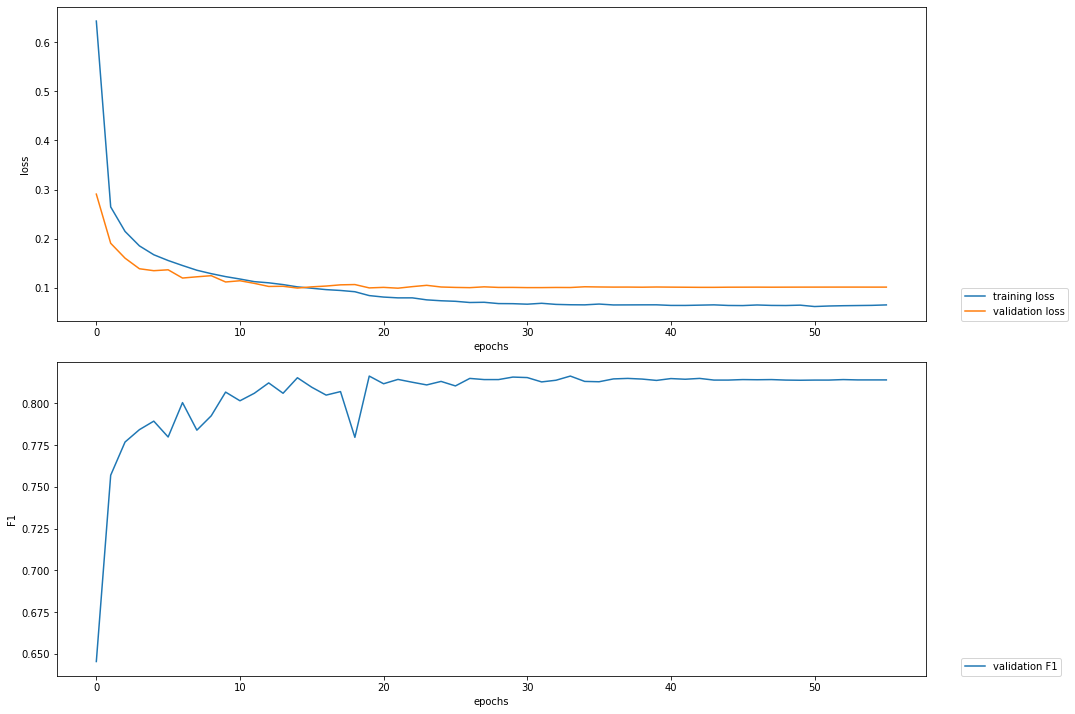

In [9]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('ner_03_results/loss.tsv')

From these plots, we notice that:
- Training was sufficiently long, since the curves have flattened out
- There are no overfitting issues, since the training and validation losses are similar

### Model-Level Performance

From the training log, we see that our model achieved **0.82 for precision, 0.81 for recall, and 0.81 for the F1 score**. Not bad for our initial model! These numbers will serve as a baseline for model performance moving forward as we iterate.

As explained in an earlier notebook, precision/recall/F1-score are the most common metrics used to assess NER performance. 

### Entity-Level Performance

In addition to model-level performance, we also want to investigate entity-level performance to see how well our model performed on identifying each of the individual entity tags.

Our training logs show:

         precision    recall  f1-score   support

    geo     0.7898    0.8879    0.8359       330
    tim     0.8912    0.8230    0.8557       209
    org     0.7000    0.6238    0.6597       202
    per     0.8286    0.8333    0.8309       174
    gpe     0.9679    0.8389    0.8988       180
    eve     0.3333    0.3333    0.3333         3
    nat     1.0000    0.2500    0.4000         4
    art     0.0000    0.0000    0.0000         4

`support` is the number of occurrences for each entity tag in the dataset. Note that `eve` (event), `nat` (natural object), and `art` (artifact) are poorly represented in our data, so it makes sense that their scores are lower since the model doesn't have many examples to learn from. `org` (organization) has a relatively low F1 score despite having a fair number of occurrences in the dataset, so we'll want to investigate this in future work.

## Run Trained Model In Inference Mode

Let's run our newly trained model in inference mode with an input sentence:

In [10]:
from flair.data import Sentence
from flair.models import SequenceTagger

input_sentence = 'The indictments were announced Tuesday by the Justice Department in Cairo.'
tagger = SequenceTagger.load("ner_03_results/final-model.pt")
sentence = Sentence(input_sentence)

tagger.predict(sentence)
print(sentence.to_tagged_string())

2022-12-03 17:03:43,739 loading file ner_03_results/final-model.pt
2022-12-03 17:03:44,645 SequenceTagger predicts: Dictionary with 35 tags: O, S-geo, B-geo, E-geo, I-geo, S-org, B-org, E-org, I-org, S-tim, B-tim, E-tim, I-tim, S-gpe, B-gpe, E-gpe, I-gpe, S-per, B-per, E-per, I-per, S-art, B-art, E-art, I-art, S-eve, B-eve, E-eve, I-eve, S-nat, B-nat, E-nat, I-nat, <START>, <STOP>
Sentence: "The indictments were announced Tuesday by the Justice Department in Cairo ." → ["Tuesday"/tim, "Justice Department"/org, "Cairo"/geo]


As shown in this example, the trained model correctly identifies all of the entity tags in the example sentence.

## Next Steps

Here are some ideas for future work:

- investigate the quality of data for `org` entity
- use Transformers as embeddings instead, and fine-tune them
- figure out the possible unknown entity in the test set
- remove test set evaluation from `ColumnCorpus`
- use a larger training set instead of 'tiny' version